In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astroquery.skyview import SkyView
import astropy.units as u
from astropy.wcs import WCS

from matplotlib.patches import Rectangle, Circle
from matplotlib import transforms
from matplotlib.widgets import Slider

# from mywidget import VertSlider

In [3]:
#Vertical Slider bar from https://stackoverflow.com/questions/25934279/add-a-vertical-slider-with-matplotlib
#Update when this is supported by matplotlib

from matplotlib.widgets import AxesWidget
import six

class VertSlider(AxesWidget):
    """
    A slider representing a floating point range.

    For the slider to remain responsive you must maintain a
    reference to it.

    The following attributes are defined
      *ax*        : the slider :class:`matplotlib.axes.Axes` instance

      *val*       : the current slider value

      *hline*     : a :class:`matplotlib.lines.Line2D` instance
                     representing the initial value of the slider

      *poly*      : A :class:`matplotlib.patches.Polygon` instance
                     which is the slider knob

      *valfmt*    : the format string for formatting the slider text

      *label*     : a :class:`matplotlib.text.Text` instance
                     for the slider label

      *closedmin* : whether the slider is closed on the minimum

      *closedmax* : whether the slider is closed on the maximum

      *slidermin* : another slider - if not *None*, this slider must be
                     greater than *slidermin*

      *slidermax* : another slider - if not *None*, this slider must be
                     less than *slidermax*

      *dragging*  : allow for mouse dragging on slider

    Call :meth:`on_changed` to connect to the slider event
    """
    def __init__(self, ax, label, valmin, valmax, valinit=0.5, valfmt='%1.2f',
                 closedmin=True, closedmax=True, slidermin=None,
                 slidermax=None, dragging=True, valstep = None, **kwargs):
        """
        Create a slider from *valmin* to *valmax* in axes *ax*.

        Additional kwargs are passed on to ``self.poly`` which is the
        :class:`matplotlib.patches.Rectangle` which draws the slider
        knob.  See the :class:`matplotlib.patches.Rectangle` documentation
        valid property names (e.g., *facecolor*, *edgecolor*, *alpha*, ...).

        Parameters
        ----------
        ax : Axes
            The Axes to put the slider in

        label : str
            Slider label

        valmin : float
            The minimum value of the slider

        valmax : float
            The maximum value of the slider

        valinit : float
            The slider initial position

        label : str
            The slider label

        valfmt : str
            Used to format the slider value, fprint format string

        closedmin : bool
            Indicate whether the slider interval is closed on the bottom

        closedmax : bool
            Indicate whether the slider interval is closed on the top

        slidermin : Slider or None
            Do not allow the current slider to have a value less than
            `slidermin`

        slidermax : Slider or None
            Do not allow the current slider to have a value greater than
            `slidermax`


        dragging : bool
            if the slider can be dragged by the mouse
        valstep : float, optional, default: None
            If given, the slider will snap to multiples of `valstep`.
        """
        AxesWidget.__init__(self, ax)

        self.valmin = valmin
        self.valmax = valmax
        self.val = valinit
        self.valinit = valinit
        self.valstep = valstep
        self.poly = ax.axhspan(valmin, valinit, 0, 1, **kwargs)

        self.hline = ax.axhline(valinit, 0, 1, color='r', lw=1)

        self.valfmt = valfmt
        ax.set_xticks([])
        ax.set_ylim((valmin, valmax))
        ax.set_yticks([])
        ax.set_navigate(False)

        self.connect_event('button_press_event', self._update)
        self.connect_event('button_release_event', self._update)
        if dragging:
            self.connect_event('motion_notify_event', self._update)
        self.label = ax.text(0.5, 1.03, label, transform=ax.transAxes,
                             verticalalignment='center',
                             horizontalalignment='center')

        self.valtext = ax.text(0.5, -0.03, valfmt % valinit,
                               transform=ax.transAxes,
                               verticalalignment='center',
                               horizontalalignment='center')

        self.cnt = 0
        self.observers = {}

        self.closedmin = closedmin
        self.closedmax = closedmax
        self.slidermin = slidermin
        self.slidermax = slidermax
        self.drag_active = False

    def _update(self, event):
        """update the slider position"""
        if self.ignore(event):
            return

        if event.button != 1:
            return

        if event.name == 'button_press_event' and event.inaxes == self.ax:
            self.drag_active = True
            event.canvas.grab_mouse(self.ax)

        if not self.drag_active:
            return

        elif ((event.name == 'button_release_event') or
              (event.name == 'button_press_event' and
               event.inaxes != self.ax)):
            self.drag_active = False
            event.canvas.release_mouse(self.ax)
            return

        val = event.ydata
        if self.valstep:
            val = np.round((val - self.valmin)/self.valstep)*self.valstep
            val += self.valmin
        if val <= self.valmin:
            if not self.closedmin:
                return
            val = self.valmin
        elif val >= self.valmax:
            if not self.closedmax:
                return
            val = self.valmax

        if self.slidermin is not None and val <= self.slidermin.val:
            if not self.closedmin:
                return
            val = self.slidermin.val

        if self.slidermax is not None and val >= self.slidermax.val:
            if not self.closedmax:
                return
            val = self.slidermax.val

        self.set_val(val)

    def set_val(self, val):
        xy = self.poly.xy
        xy[1] = 0, val
        xy[2] = 1, val
        self.poly.xy = xy
        self.valtext.set_text(self.valfmt % val)
        if self.drawon:
            self.ax.figure.canvas.draw_idle()
        self.val = val
        if not self.eventson:
            return
        for cid, func in six.iteritems(self.observers):
            func(val)

    def on_changed(self, func):
        """
        When the slider value is changed, call *func* with the new
        slider position

        A connection id is returned which can be used to disconnect
        """
#         print('foo')
        cid = self.cnt
        self.observers[cid] = func
        self.cnt += 1
        return cid

    def disconnect(self, cid):
        """remove the observer with connection id *cid*"""
        try:
            del self.observers[cid]
        except KeyError:
            pass

    def reset(self):
        """reset the slider to the initial value if needed"""
        if (self.val != self.valinit):
            self.set_val(self.valinit)

# Define coordinates of your source and offset star

In [5]:
target_name = 'SPIRITS18eo'
target_string = '09:32:06.32  21:30:14.23'
offset_string = '09:32:05.10  21:30:58.87'

In [6]:
#Your source and offset star
coords =        SkyCoord(target_string, unit = (u.hourangle, u.deg)) #source
coords_offset = SkyCoord(offset_string, unit = (u.hourangle, u.deg)) #source

# Download image

In [7]:
image_server = 'DSS2 Red'

In [8]:
img = SkyView.get_images(position=coords,survey=[image_server]\
                         ,pixels='800,800',coordinates='J2000',grid=True,gridlabels=True)


In [9]:
#ONE ARCSEC PER PIX

# Plot the image with slit and guider FoV

<IPython.core.display.Javascript object>


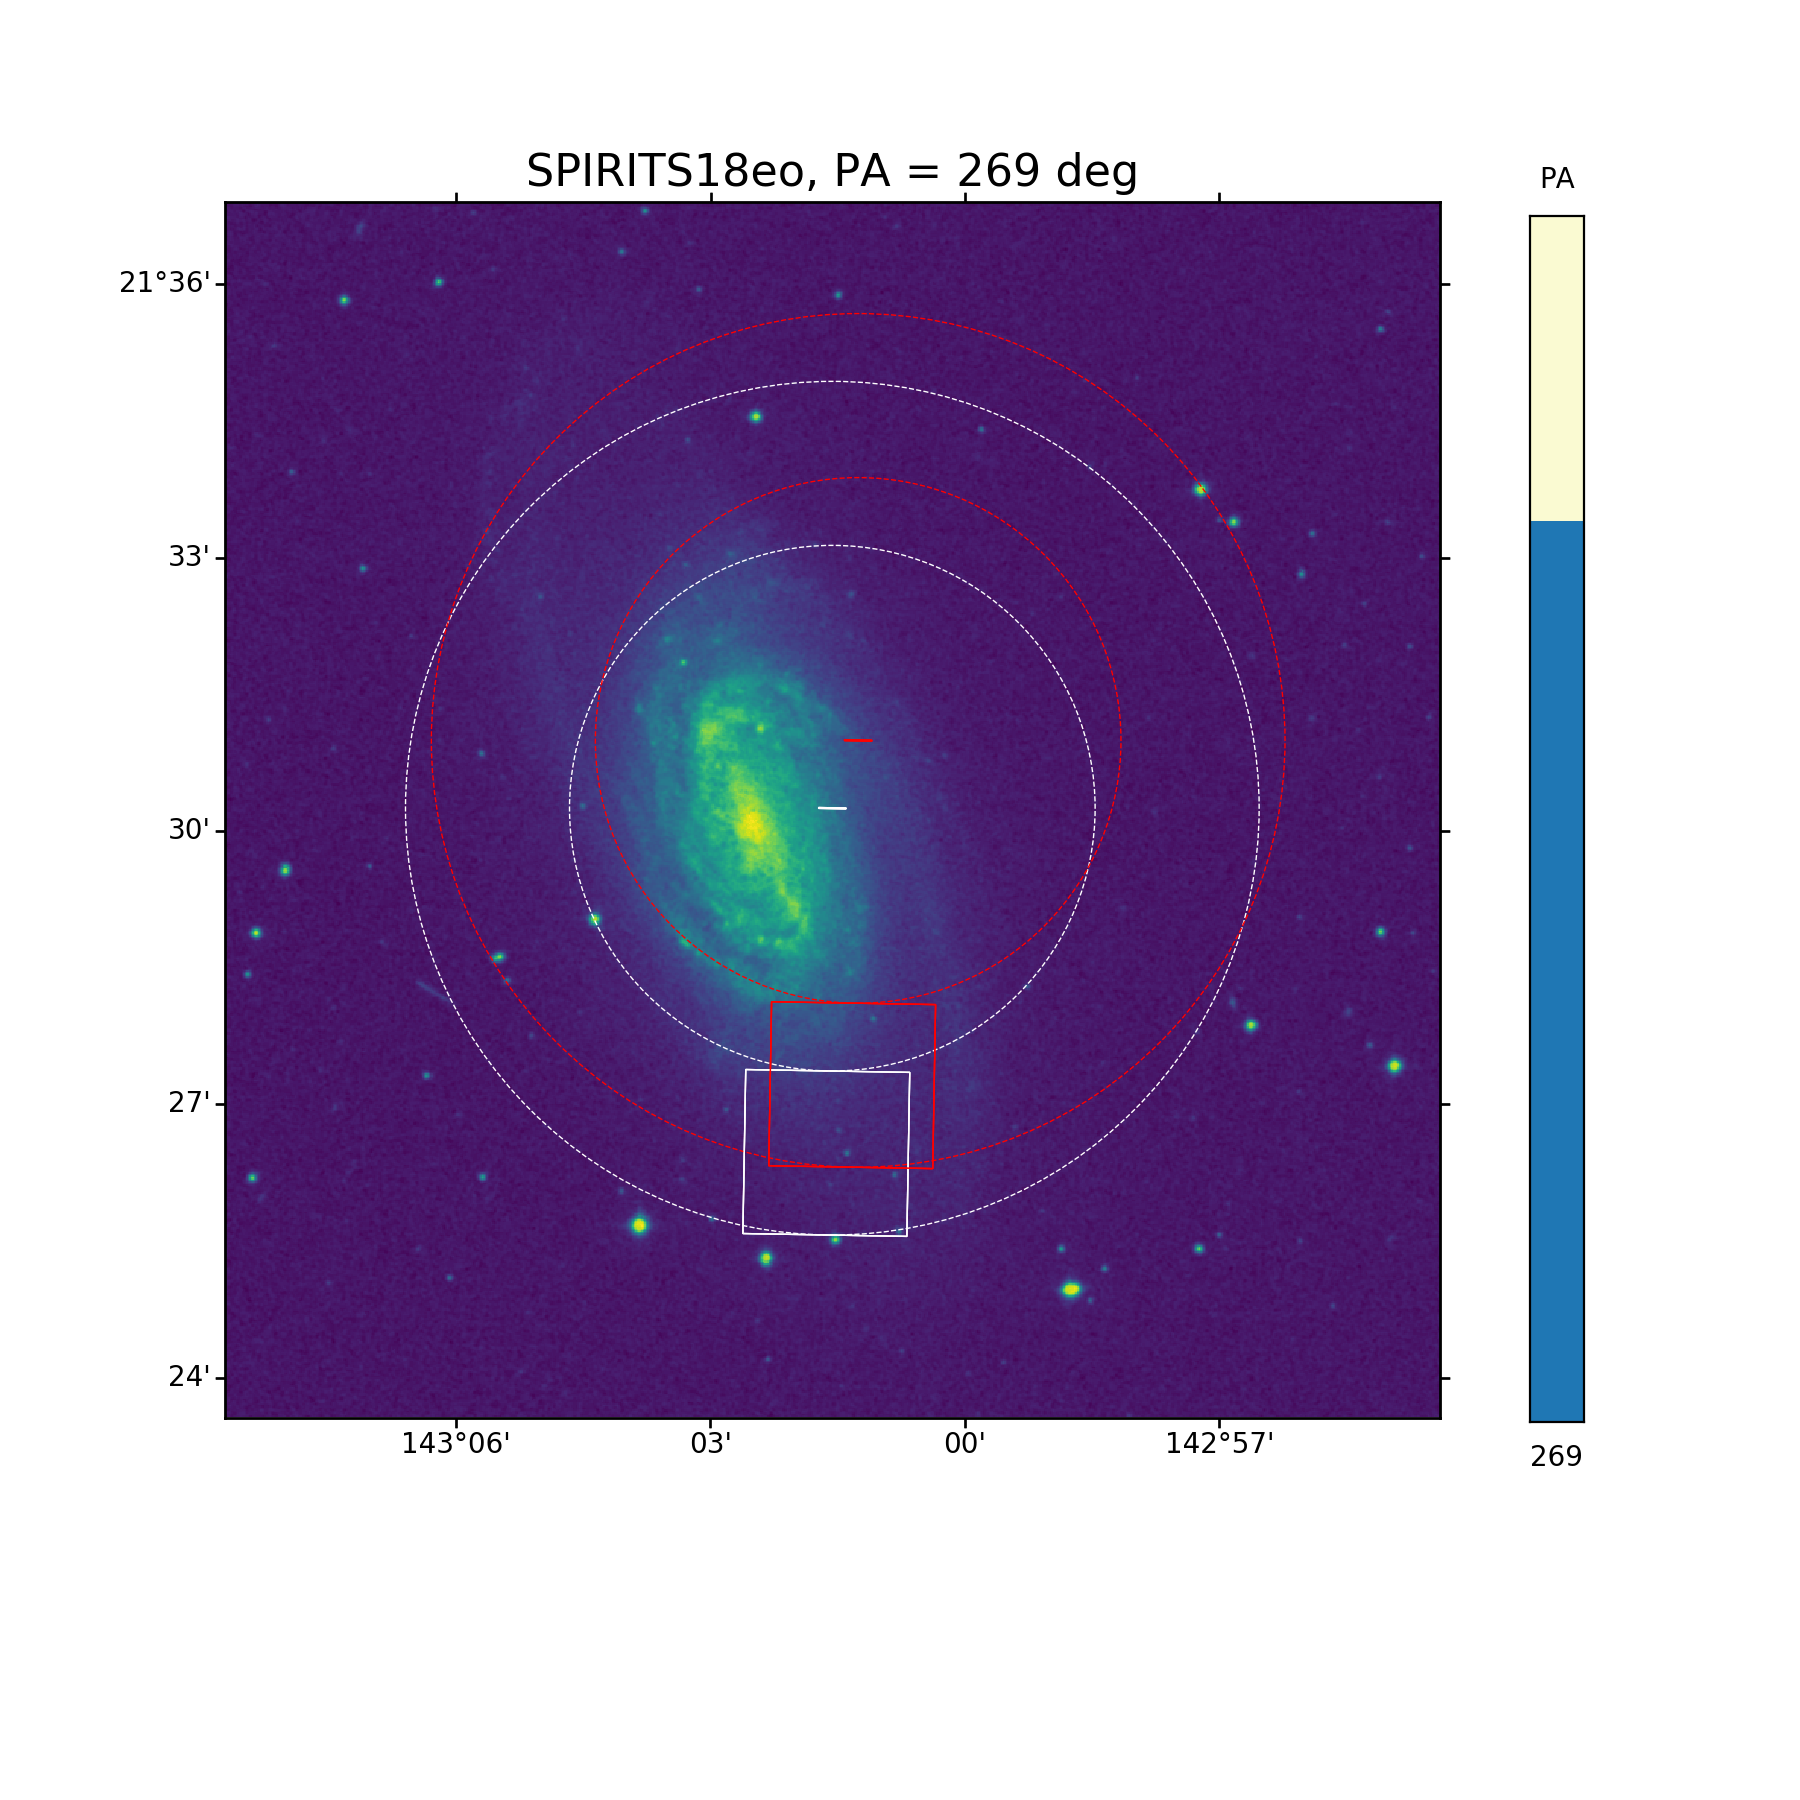

In [11]:
wcs = WCS(img[0][0].header)
plt.figure(figsize = (9,9))
ax = plt.subplot(projection = wcs)
ax.imshow(img[0][0].data, origin = 'lower')

#picture coordinates of source and offset star
x, y = wcs.all_world2pix([coords.ra.deg], [coords.dec.deg], 1)
xo, yo = wcs.all_world2pix([coords_offset.ra.deg], [coords_offset.dec.deg], 1)

#dimension of slit
dx = 0.55/2 #0.55"
dy = 18/2 #18"

#Define slit for source and offset star
slit = Rectangle((x[0]-dx, y[0]-dy), 2*dx, 2*dy, color = 'w', lw = 0.5)
slit_o = Rectangle((xo[0]-dx, yo[0]-dy), 2*dx, 2*dy, color = 'r', lw = 0.5)

#Define guider field for source and offset star
guider_dx = 3.44*60*1.1 #...shouldn't this number be known?
guider_dim = 1.8*60
Guider = Rectangle((x[0]+guider_dx-guider_dim/2, y[0]-guider_dim/2), guider_dim,guider_dim, \
                   color = 'w', fill = False, lw = 0.5)#, \
                   #transform = transforms.Affine2D.rotate_around(x = x[0],y =  y[0],theta =  np.radians(PA)))

Guider_o = Rectangle((xo[0]+guider_dx-guider_dim/2, yo[0]-guider_dim/2), guider_dim,guider_dim, \
                   color = 'r', fill = False, lw = 0.5)

#Define guider circle for source and offset star
Guider_path_in  = Circle((x[0], y[0]), guider_dx-guider_dim/2, fill = False, color = 'w', lw = 0.5,ls = '--')
Guider_path_out = Circle((x[0], y[0]), guider_dx+guider_dim/2, fill = False, color = 'w', lw = 0.5,ls = '--')

Guider_o_path_in  = Circle((xo[0], yo[0]), guider_dx-guider_dim/2, fill = False, color = 'r', lw = 0.5, ls = '--')
Guider_o_path_out = Circle((xo[0], yo[0]), guider_dx+guider_dim/2, fill = False, color = 'r', lw = 0.5, ls = '--')


#ROTATE

# for i in range(0,370,30):
PA = 0

rot = transforms.Affine2D().rotate_around(x[0], y[0],np.radians(PA))+ ax.transData
rot_o = transforms.Affine2D().rotate_around(xo[0], yo[0],np.radians(PA))+ ax.transData

Guider.set_transform(rot)
slit.set_transform(rot)
Guider_o.set_transform(rot_o)
slit_o.set_transform(rot_o)


ax.add_patch(slit)
ax.add_patch(Guider)
ax.add_patch(slit_o)
ax.add_patch(Guider_o)

ax.add_patch(Guider_path_in )
ax.add_patch(Guider_path_out)
ax.add_patch(Guider_o_path_in )
ax.add_patch(Guider_o_path_out)

ax.set_title('%s, PA = %d deg'%(target_name,PA), fontsize = 16)

#Slider 
plt.subplots_adjust(right=0.8, bottom=0., top = 1.1)

axPA= plt.axes([0.85, 0.21, 0.03,0.67], facecolor='lightgoldenrodyellow')
sPA = VertSlider(axPA, 'PA', 0, 360, valinit=0, valstep=1, valfmt = '%d', dragging = True)

# sPA.set_val(10)
def update(val):
    PA = sPA.val
    rot = transforms.Affine2D().rotate_around(x[0], y[0],np.radians(PA))+ ax.transData
    rot_o = transforms.Affine2D().rotate_around(xo[0], yo[0],np.radians(PA))+ ax.transData
    #rerotate and draw boxes
    Guider.set_transform(rot)
    slit.set_transform(rot)
    Guider_o.set_transform(rot_o)
    slit_o.set_transform(rot_o)


    ax.add_patch(slit)
    ax.add_patch(Guider)
    ax.add_patch(slit_o)
    ax.add_patch(Guider_o)
    ax.set_title('%s, PA = %d deg'%(target_name,PA), fontsize = 16)


cid =sPA.on_changed(update)

# plt.tight_layout()


# ax.text(0.8*img[0][0].data.shape[0], 0.8*img[0][0].data.shape[1], 'PA = %.1f deg'%PA, fontsize = 50, color = 'w')

# plt.savefig('%s_PA%.1f.pdf'%(target_name,PA))